In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from torch_geometric.nn import global_add_pool, GATConv, CGConv, VGAE,GCNConv, RGCNConv, global_mean_pool
import pickle
from itertools import combinations
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader, Data
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from tqdm import tqdm
import torch.optim as optim
import math
from torch_geometric.data import DataLoader
from torch_geometric.nn import RGCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset, DataLoader
import pickle
from torch.optim import Adam, RMSprop
from tqdm import tqdm
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import pandas as pd
import pickle



In [2]:
from contextlib import contextmanager
import sys
import os
import torch
from ase import Atoms
from ase.data import chemical_symbols
from ase.calculators.morse import MorsePotential
from ase.optimize import QuasiNewton
import numpy as np
import pickle
from rdkit.Chem import rdchem

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ase import Atoms
from ase.io import read
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
# from torch_geometric.data import DataLoader, TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from ase.build import molecule
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from torch_geometric.nn import global_add_pool, GATConv, CGConv, GCNConv, RGCNConv
from torch_geometric.nn.models.schnet import GaussianSmearing
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle
from collections import Counter
import seaborn as sns
import time
from torch.optim.lr_scheduler import StepLR
import torch
from torch_geometric.data import Data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def debug_nan(tensor, name="Tensor"):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        print(tensor)

In [5]:
class RGCN_VGAE(nn.Module):
    def __init__(self, in_channels, out_channels, num_relations, num_node_features, max_nodes, bond_dim, atom_dim):
        super(RGCN_VGAE, self).__init__()
        self.num_relations = num_relations
        self.max_nodes = max_nodes
        self.atom_dim = atom_dim
        self.bond_dim = bond_dim

        self.rgcn1 = RGCNConv(in_channels, out_channels, num_relations=num_relations)
        self.rgcn2 = RGCNConv(out_channels, out_channels, num_relations=num_relations)
        self.rgcn3 = RGCNConv(out_channels, out_channels, num_relations=num_relations)
        
        self.fc_mu = nn.Linear(out_channels, out_channels)
        self.fc_logvar = nn.Linear(out_channels, out_channels)
        
        self.adj_decoder = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, max_nodes * max_nodes * bond_dim)
        )
        self.feature_decoder = nn.Linear(out_channels, max_nodes * atom_dim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        edge_attr = torch.argmax(edge_attr, dim=1).long()

        # print(x.shape)
        # print(edge_index.shape)
        # print(edge_attr.shape)
        x = F.relu(self.rgcn1(x, edge_index, edge_attr))
        x = F.relu(self.rgcn2(x, edge_index, edge_attr))
        # x = F.relu(self.rgcn3(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)

        A_pred = self.adj_decoder(z).view(-1, self.max_nodes, self.max_nodes, self.bond_dim)
        A_pred = F.softmax(A_pred, dim=-1)

        features_pred = self.feature_decoder(z).view(-1, self.max_nodes, self.atom_dim)
        features_pred = F.softmax(features_pred, dim=-1)
        
        return A_pred, features_pred, mu, logvar
    
    def decode(self, z):    
        A_pred = self.adj_decoder(z).view(-1, self.max_nodes, self.max_nodes, self.bond_dim)
        A_pred = F.softmax(A_pred, dim=-1)

        features_pred = self.feature_decoder(z).view(-1, self.max_nodes, self.atom_dim)
        features_pred = F.softmax(features_pred, dim=-1)
        
        return A_pred, features_pred

In [6]:
# with open("../data/combined_data.pkl", "rb") as file:
#     combined_data = pickle.load(file)

atomic_number_tensors = torch.load("data/atomic_number_tensors.pt")
bond_tensors = torch.load("data/bond_tensors.pt")

In [7]:
NUM_ATOMS = 63
ATOM_DIM = 11
BOND_DIM = 5
LATENT_DIM = 256
HIDDEN_CHANNELS = 128
NUM_RELATION_TYPES = BOND_DIM - 1
NODE_FEATURE_DIM = ATOM_DIM - 1
# NODE_FEATURE_DIM = ATOM_DIM
BATCH_SIZE = 512
NUM_EPOCHS = 300

In [8]:
model = RGCN_VGAE(NODE_FEATURE_DIM, LATENT_DIM, NUM_RELATION_TYPES, NODE_FEATURE_DIM, NUM_ATOMS, BOND_DIM, ATOM_DIM).to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
class GraphDataset(Dataset):
    def __init__(self, adjacency_matrices, atom_features):
        self.adjacency_matrices = adjacency_matrices
        self.atom_features = atom_features

    def __len__(self):
        return self.adjacency_matrices.size(0)

    def __getitem__(self, idx):
        return self.adjacency_matrices[idx], self.atom_features[idx]
    
dataset = GraphDataset(bond_tensors, atomic_number_tensors)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
weights_atoms = torch.ones(ATOM_DIM).to(device)
weights_bonds = torch.ones(BOND_DIM).to(device)

weights_atoms[0] = 0.8
weights_atoms[10] = 5
weights_bonds[4] = 2

weights_atoms.to(device)
weights_bonds.to(device)

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence

def loss_function(preds, labels, mu, logvar, preds_atomic, atomic_numbers, lambda_kld, device):

    batch_size = preds.shape[0]
    labels = torch.argmax(labels, dim=-1)
    atomic_numbers = torch.argmax(atomic_numbers, dim=-1)
    preds, labels = preds.to(device), labels.to(device)
    preds_atomic, atomic_numbers = preds_atomic.to(device), atomic_numbers.to(device)
    mu, logvar = mu.to(device), logvar.to(device)

    # print(preds.shape)
    # print(labels.shape)
    # print(preds_atomic.shape)
    # print(atomic_numbers.shape)

    ce_bond = F.cross_entropy(preds.view(-1, preds.size(-1)), labels.view(-1), weight=weights_bonds.to(device))
    ce_atomic = F.cross_entropy(preds_atomic.view(-1, preds_atomic.size(-1)), atomic_numbers.view(-1), weight=weights_atoms.to(device))
    
    kld = calculate_kl_divergence(mu, logvar)

    atom_presence_mask = torch.argmax(preds_atomic, dim=-1) != 10
    atom_count = torch.sum(atom_presence_mask)
    atomic_regulizer = atom_count / batch_size * 3


    bond_presence_mask = torch.argmax(preds, dim=-1) != 4
    bond_count = torch.sum(bond_presence_mask)
    bond_count = bond_count / batch_size

    if atom_count / batch_size <= 7:
        atomic_regulizer = 150 - 10 * atom_count

    if bond_count < 19:
        bond_regulizer = 0.0
    elif bond_count <= 4:
        bond_regulizer = 150 - 10 * bond_count
    else:
        bond_regulizer = bond_count * 3

    total_loss = 0.8 * ce_bond + lambda_kld * kld + 1.5 * ce_atomic + atomic_regulizer + bond_regulizer

    # print(CE_bond, KLD, CE_atomic, atomic_regulizer, bond_regulizer)
    return total_loss


In [12]:
def process_graph_data_to_data_objects(batch_adjacency, batch_atoms, grad = False):
    batch_size = batch_adjacency.shape[0]
    num_nodes = batch_adjacency.shape[1]
    num_bond_types = batch_adjacency.shape[3] - 1 
    num_atom_types = batch_atoms.shape[2] - 1
    # print(num_atom_types)
    
    data_objects = []

    for idx in range(batch_size):
        edge_index = []
        edge_attr = []
        x = []
        node_index_map = {}
        
        adjacency = batch_adjacency[idx]
        atoms = batch_atoms[idx]
        
        new_idx = 0

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                bond_type = torch.argmax(adjacency[i, j])
                # if adjacency[i,j][num_bond_types] > 0.18:
                #     # print('overwrite')
                    # continue
                if bond_type < num_bond_types:  # Bond exists
                    atom_type_i = torch.argmax(atoms[i])
                    atom_type_j = torch.argmax(atoms[j])
                    if atom_type_i == num_atom_types or atom_type_j == num_atom_types: # Both atoms must exist
                        continue
                    if i not in node_index_map:
                        node_index_map[i] = new_idx
                        new_idx+=1
                        x.append(torch.nn.functional.one_hot(torch.argmax(atoms[i]), num_classes=num_atom_types).float())
                    if j not in node_index_map:
                        node_index_map[j] = new_idx
                        new_idx+=1
                        x.append(torch.nn.functional.one_hot(torch.argmax(atoms[j]), num_classes=num_atom_types).float())
                    edge_index.append([node_index_map[i], node_index_map[j]])
                    bond_one_hot = torch.zeros(num_bond_types)
                    bond_one_hot[bond_type] = 1
                    edge_attr.append(bond_one_hot)
                    # print(bond_type)
                    # edge_attr.append(bond_type/num_bond_types)

        if edge_index:
            edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr_tensor = torch.stack(edge_attr, dim=0)

        else:
       
            edge_index_tensor = torch.empty((2, 0), dtype=torch.long)
            edge_attr_tensor = torch.empty((0, num_bond_types), dtype=torch.float)
            

        if x:
            node_features_tensor = torch.stack(x, dim=0)
        else:
           
            node_features_tensor = torch.empty((0, num_atom_types), dtype=torch.float)

   
        # if grad:
        #     node_features_tensor.requires_grad_(True)
        #     edge_attr.requires_grad_(True)
        graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor, adj_matrix=adjacency, node_features=atoms)
        data_objects.append(graph_data)

    return data_objects

In [13]:
data_dataset = []
for adj_matrix, node_features in dataloader:
    adj_matrix.to(device)
    node_features.to(device)
    data = process_graph_data_to_data_objects(adj_matrix, node_features)
    data_dataset.append(data)

data_object_loader = DataLoader(data_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
for b in data_object_loader:
    print(b)
    break

[DataBatch(x=[134, 10], edge_index=[2, 138], edge_attr=[138, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[134], ptr=[8]), DataBatch(x=[129, 10], edge_index=[2, 131], edge_attr=[131, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[129], ptr=[8]), DataBatch(x=[150, 10], edge_index=[2, 155], edge_attr=[155, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[150], ptr=[8]), DataBatch(x=[122, 10], edge_index=[2, 125], edge_attr=[125, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[122], ptr=[8]), DataBatch(x=[124, 10], edge_index=[2, 128], edge_attr=[128, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[124], ptr=[8]), DataBatch(x=[147, 10], edge_index=[2, 151], edge_attr=[151, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[147], ptr=[8]), DataBatch(x=[132, 10], edge_index=[2, 134], edge_attr=[134, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], batch=[132], ptr=[8]), DataBatch(x=[144, 10], edge_index=[2, 14

In [15]:
num_epochs = 700
for epoch in range(num_epochs):
    total_loss = 0
    #lambda_kld = min(1.0, 0.01 +  epoch/ num_epochs)
    lambda_kld = 1.0
    batch_count = 0
    for data in data_object_loader:
        # print(adj_matrix.shape)
        optimizer.zero_grad()

        # adj_matrix.to(device)
        # node_features.to(device)
        
        # data = process_graph_data_to_data_objects(adj_matrix, node_features)
        data = Batch.from_data_list(data).to(device)

        reconstructed, reconstructed_atoms, mu, logvar = model(data)
        
        loss = loss_function(
            reconstructed, data.adj_matrix, 
            mu, logvar, 
            reconstructed_atoms, data.node_features, 
            lambda_kld, device
        )
        total_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        print(f"Gradients of {name}: {param.grad}")

    # Calculate average loss for reporting
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 10207.7158203125
Epoch 2, Loss: 10029.669921875
Epoch 3, Loss: 9857.6318359375
Epoch 4, Loss: 9679.1953125
Epoch 5, Loss: 9494.3134765625
Epoch 6, Loss: 9314.7490234375
Epoch 7, Loss: 9128.42578125
Epoch 8, Loss: 8939.654296875
Epoch 9, Loss: 8753.3037109375
Epoch 10, Loss: 8554.2734375
Epoch 11, Loss: 8355.9130859375
Epoch 12, Loss: 8161.2255859375
Epoch 13, Loss: 7961.8486328125
Epoch 14, Loss: 7760.1181640625
Epoch 15, Loss: 7550.5205078125
Epoch 16, Loss: 7349.482421875
Epoch 17, Loss: 7136.03369140625
Epoch 18, Loss: 6938.193359375
Epoch 19, Loss: 6735.7001953125
Epoch 20, Loss: 6523.09912109375
Epoch 21, Loss: 6308.04248046875
Epoch 22, Loss: 6090.83984375
Epoch 23, Loss: 5883.10693359375
Epoch 24, Loss: 5673.95556640625
Epoch 25, Loss: 5473.40771484375
Epoch 26, Loss: 5267.69677734375
Epoch 27, Loss: 5062.01904296875
Epoch 28, Loss: 4867.59326171875
Epoch 29, Loss: 4657.04638671875
Epoch 30, Loss: 4468.37646484375
Epoch 31, Loss: 4278.4775390625
Epoch 32, Loss: 40

### Use if Sampling with Conditioning

In [16]:
def get_dist():
    model.eval()
    with torch.no_grad(): 
        for data in data_object_loader: 
            data = Batch.from_data_list(data).to(device)
            _, _, mu, logvar = model(data)
            return mu, logvar
    

In [17]:
def sample_z_ours(mu, logvar, num_samples=1):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [18]:
def generate_graph_ours(model, num_samples=1, latent_dim=256, device="cuda"):
    mmu, llog = get_dist()
    sampled_ours = sample_z_ours(mmu, llog)
    
    with torch.no_grad(): 
        A_pred, features_pred = model.decode(sampled_ours)
    
    return A_pred, features_pred

### Use if Sampling without Conditioning

In [19]:
def sample_z(latent_dim, num_samples=1, device="cuda"):
    return torch.randn(num_samples, latent_dim).to(device)

In [20]:
def generate_graph(model, num_samples=1, latent_dim=256, device="cuda"):
    z = sample_z(latent_dim, num_samples, device)
    
    with torch.no_grad(): 
        A_pred, features_pred = model.decode(z)
    
    return A_pred, features_pred

In [21]:
# #one_hot_bond_reduced, one_hot_atoms_reduced = drop_extras(one_hot_bond[0].view(1,63, 63, 5), one_hot_atoms[0].view(1, 63,11))

# datapoints = process_graph_data_to_data_objects(bonds_pred, atoms_pred)

In [22]:
atomic_mapping = {0: 6, 1: 7, 2:8, 3:9, 4:14, 5:15, 6:16, 7:17, 8:35, 9:53}

In [23]:
def get_bond_type(bond_type):
    bond_type = torch.argmax(bond_type, dim=-1).item()
    if bond_type == 0:
        return rdchem.BondType.SINGLE
    elif bond_type == 1:
        return rdchem.BondType.DOUBLE
    elif bond_type == 2:
        return rdchem.BondType.TRIPLE
    elif bond_type == 3:
        return rdchem.BondType.AROMATIC
    else:
        return None

In [24]:
def is_valid(data):
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    atomic_numbers = []
    for num in node_features.argmax(dim=-1).tolist():
        atomic_numbers.append(atomic_mapping[num])

    mol = Chem.RWMol()
    for atomic_num in atomic_numbers:
        atom = Chem.Atom(atomic_num)
        mol.AddAtom(atom)

    for i, (bond_start, bond_end) in enumerate(edge_index.t().tolist()):
        bond_val = edge_attr[i]
        bond_type = get_bond_type(bond_val)
        mol.AddBond(bond_start, bond_end, bond_type)

    validity = Chem.SanitizeMol(mol, catchErrors=True)

    return validity == Chem.SanitizeFlags.SANITIZE_NONE

In [25]:
unique_molecules = set()
def is_unique(data):
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    atomic_numbers = []
    for num in node_features.argmax(dim=-1).tolist():
        atomic_numbers.append(atomic_mapping[num])

    mol = Chem.RWMol()
    for atomic_num in atomic_numbers:
        atom = Chem.Atom(atomic_num)
        mol.AddAtom(atom)

    for i, (bond_start, bond_end) in enumerate(edge_index.t().tolist()):
        bond_val = edge_attr[i]
        bond_type = get_bond_type(bond_val)
        mol.AddBond(bond_start, bond_end, bond_type)

    canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    if canonical_smiles not in unique_molecules:
        unique_molecules.add(canonical_smiles)
        return True
    else:
        return False

In [26]:
torch.save(model.state_dict(), "models/vae_model_best.pt")

In [27]:
print(model)

RGCN_VGAE(
  (rgcn1): RGCNConv(10, 256, num_relations=4)
  (rgcn2): RGCNConv(256, 256, num_relations=4)
  (rgcn3): RGCNConv(256, 256, num_relations=4)
  (fc_mu): Linear(in_features=256, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=256, bias=True)
  (adj_decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=19845, bias=True)
  )
  (feature_decoder): Linear(in_features=256, out_features=693, bias=True)
)


In [28]:
import re
def expand_formula(formula):
    pattern = r'([A-Z][a-z]?)(\d*)'
    expanded_list = []

    # Find all matches of the pattern
    matches = re.findall(pattern, formula)
    for element, count in matches:
        # Convert the count to an integer, default to 1 if empty
        count = int(count) if count else 1
        # Extend the list with the element repeated 'count' times
        expanded_list.extend([element] * count)

    return expanded_list

In [29]:
def get_molecule(datapoint):
    _, formula = to_chemula(datapoint)
    l = expand_formula(formula)

    # #atomic_numbers = datapoint.x.argmax(dim=1).tolist()
    # atomic_numbers_unmapped = datapoint.x.argmax(dim=1).tolist()
    # atomic_numbers = []
    # for at in atomic_numbers_unmapped:
    #     atomic_numbers.append(atomic_mapping[at])
    # positions = datapoint.positions.numpy()
    positions = np.random.rand(len(l), 3) * 10  

    # molecule = Atoms(numbers=atomic_numbers, positions=positions)
    molecule = Atoms(symbols=l, positions=positions)

    return molecule

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def get_dft(datapoint, De=0.242, re=0.74, alpha=1.5):
    molecule = get_molecule(datapoint)
    print('Molecule:', molecule)
    dft_calculator = MorsePotential(De=De, r0=re, alpha=alpha)
    molecule.set_calculator(dft_calculator)
    # energy = molecule.get_potential_energy()
    with suppress_stdout():
        opt = QuasiNewton(molecule)
        opt.run(fmax=0.02)
    optimized_energy = molecule.get_potential_energy()
    return optimized_energy

# energy = get_dft(datapoint)

# print(f'DFT Energy: {energy} eV')

In [41]:
def to_chemula(data):
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    atomic_numbers = []
    for num in node_features.argmax(dim=-1).tolist():
        atomic_numbers.append(atomic_mapping[num])

    mol = Chem.RWMol()
    for atomic_num in atomic_numbers:
        atom = Chem.Atom(atomic_num)
        mol.AddAtom(atom)

    for i, (bond_start, bond_end) in enumerate(edge_index.t().tolist()):
        bond_val = edge_attr[i]
        bond_type = get_bond_type(bond_val)
        mol.AddBond(bond_start, bond_end, bond_type)
        
    for atom in mol.GetAtoms():
        atom.UpdatePropertyCache(strict=False)
    # smile = Chem.MolToSmiles(mol)
    # Chem.MolFromSmiles(smile)
    
    # Chem.SanitizeMol(mol)
    return mol, CalcMolFormula(mol)

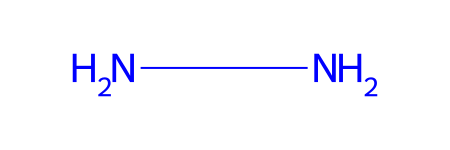

In [31]:
Chem.MolFromSmiles('NN')

In [32]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, num_relations):
        super(GraphEncoder, self).__init__()
        self.rgcnconv1 = RGCNConv(input_dim, 512, num_relations=num_relations)
        self.rgcnconv2 = RGCNConv(512, 256, num_relations=num_relations)
        self.rgcnconv3 = RGCNConv(256, 128, num_relations=num_relations)

    def forward(self, x, edge_index, edge_attr):
        x = self.rgcnconv1(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        x = self.rgcnconv2(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        x = self.rgcnconv3(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        return x

class BioClassifier(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(BioClassifier, self).__init__()

        self.encoder = GraphEncoder(input_dim, num_heads)
        self.fc1 = nn.Linear(128, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = x.float()

        x = self.encoder(x, edge_index, edge_attr)
        x = global_add_pool(x, data.batch)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.squeeze(dim=1)

In [33]:
model_bio_eval = BioClassifier(10, 4).to(device)

state_dict = torch.load('models/rcgn_model_7428.pt')
model_bio_eval.load_state_dict(state_dict)

model_bio_eval.eval()
def get_model_prediction(datapoint):
    pred = model_bio_eval(datapoint)
    return pred.item()

In [34]:
# print(datapoint)
# datapoint.edge_attr = torch.argmax(datapoint.edge_attr, dim=1).to(device)
# datapoint.edge_index = datapoint.edge_index.to(device)
# datapoint.x = datapoint.x.to(device)

In [35]:
# print(datapoint.edge_attr)

In [36]:
# dft = get_dft(datapoint)
# y = get_model_prediction(datapoint) * 100

# print(f'DFT (remember negative is good): {dft}')
# print(f'Chance of Biodgradability: {y:.2f}%')

## Generating from Our Latent Space

In [37]:
# generated_list_ours = []
# list_len = 100
# for i in tqdm(range(list_len)):
#     bonds_pred_ours, atoms_pred_ours = generate_graph_ours(model)
#     datapoints = process_graph_data_to_data_objects(bonds_pred_ours, atoms_pred_ours)
#     datapoint = datapoints[0]
#     validity = is_valid(datapoint)
#     mol, formula = to_chemula(datapoint)
#     ase_atoms = get_molecule(datapoint)
#     energy = get_dft(datapoint)
#     datapoint.edge_attr = torch.argmax(datapoint.edge_attr, dim=1).to(device)
#     datapoint.edge_index = datapoint.edge_index.to(device)
#     datapoint.x = datapoint.x.to(device)
#     y = get_model_prediction(datapoint) * 100
#     generated_list_ours.append({"bond_preds": bonds_pred, "atom_preds": atoms_pred, "is_valid": validity, "ase_atom": ase_atoms, "mol": mol, "formula": formula, "energy":energy, "bio":y})

## Generating from Rand Normal Distribution

In [42]:
generated_list = []
num_errors = 0
while len(generated_list) < 100:
    try:
        bonds_pred, atoms_pred = generate_graph(model)
        datapoints = process_graph_data_to_data_objects(bonds_pred, atoms_pred)
        datapoint = datapoints[0]
        validity = is_valid(datapoint)
        mol, formula = to_chemula(datapoint)
        ase_atoms = get_molecule(datapoint)
        energy = get_dft(datapoint)
        datapoint.edge_attr = torch.argmax(datapoint.edge_attr, dim=1).to(device)
        datapoint.edge_index = datapoint.edge_index.to(device)
        datapoint.x = datapoint.x.to(device)
        y = get_model_prediction(datapoint) * 100
        generated_list.append({"bond_preds": bonds_pred, "atom_preds": atoms_pred, "is_valid": validity, "ase_atom": ase_atoms, "mol": mol, "formula": formula, "energy":energy, "bio":y})
    except Exception as e:
        num_errors += 1
        print("ERROR!!!!!!")
        print(e)

Molecule: Atoms(symbols='C2H6', pbc=False)
Molecule: Atoms(symbols='C2H6', pbc=False)
Molecule: Atoms(symbols='HIO', pbc=False)
Molecule: Atoms(symbols='CH4S', pbc=False)
Molecule: Atoms(symbols='H4N2', pbc=False)
Molecule: Atoms(symbols='C2H6', pbc=False)
Molecule: Atoms(symbols='CH4O', pbc=False)
Molecule: Atoms(symbols='CH4O', pbc=False)
Molecule: Atoms(symbols='C2H6', pbc=False)
Molecule: Atoms(symbols='', pbc=False)
ERROR!!!!!!
zero-size array to reduction operation maximum which has no identity
Molecule: Atoms(symbols='C2H6', pbc=False)
Molecule: Atoms(symbols='CH4O', pbc=False)
Molecule: Atoms(symbols='C2H6', pbc=False)
Molecule: Atoms(symbols='HBrS', pbc=False)
Molecule: Atoms(symbols='H4NP', pbc=False)
Molecule: Atoms(symbols='BrI', pbc=False)
Molecule: Atoms(symbols='H3ClSi', pbc=False)
Molecule: Atoms(symbols='CH5N', pbc=False)
Molecule: Atoms(symbols='CH4O', pbc=False)
Molecule: Atoms(symbols='CH5N', pbc=False)
Molecule: Atoms(symbols='CH4O', pbc=False)
Molecule: Atoms(symb

In [ ]:
print(len(generated_list))

100


In [ ]:
print(generated_list[0]["ase_atom"])

Atoms(symbols='CH4O', pbc=False)


In [43]:
unique_formulas = set()
count_formulas = {}
count_valid = 0
for item in generated_list:
    if 'formula' in item:
        if item['formula'] not in count_formulas:
            count_formulas[item['formula']] = 1
        else:
            count_formulas[item['formula']] += 1
        unique_formulas.add(item['formula'])
    if 'is_valid' in item:
        if item['is_valid'] == True:
            count_valid += 1
        

In [44]:
print(unique_formulas)
print("Number of Unique Formulas: ", len(unique_formulas))
print("Number of Valid Formulas: ", count_valid / (num_errors + count_valid))

{'CH5P', 'BrI', 'C2H6', 'CH6Si', 'CH3Cl', 'H2FN', 'H3ISi', 'HBrS', 'CH5N', 'H4SSi', 'HIO', 'H2ClP', 'H4NP', 'H3NO', 'H5NSi', 'H3OP', 'H2ClN', 'CH4O', 'H2O2', 'HBrO', 'CH3I', 'H3NS', 'H4OSi', 'CH3Br', 'H2BrN', 'CH4S', 'H3ClSi', 'HClO', 'H4N2', 'HFO'}
Number of Unique Formulas:  30
Number of Valid Formulas:  0.970873786407767


In [ ]:
print(count_formulas)

{'CH4O': 9, 'HIO': 3, 'HBrO': 3, 'H4P2': 1, 'H3NO': 4, 'CH3Cl': 3, 'H2BrN': 2, 'H5NSi': 2, 'CH5N': 20, 'H4N2': 4, 'H2ClN': 3, 'H2O2': 3, 'H3PS': 2, 'CH6Si': 2, 'HFS': 2, 'C2H6': 13, 'H4OSi': 1, 'CH5P': 3, 'CH3I': 3, 'CH3F': 1, 'H2OS': 1, 'CH4S': 1, 'H4NP': 2, 'H4SSi': 3, 'CH3Br': 1, 'HClO': 2, 'H3OP': 1, 'H2FN': 3, 'H2IN': 1, 'H2BrP': 1}


### Novelty

In [45]:
with open("data/og_formulas.pkl", "rb") as file:
    og_formulas = pickle.load(file)

In [46]:
print(og_formulas)
print(len(og_formulas))

['C4H10O2S2', 'C17H11BrClFN2O4', 'C7H7Br', 'C7H16BrN', 'C2HBrCl2O2', 'C4H6Br2', 'CBrCl3', 'C6H5F2N', 'C11H20O', 'C6BrF5', 'C10H24N2O4', 'C6H4ClNO2', 'C6H14O3', 'C10H22O5', 'C2H3BrO2', 'C8H18BrN', 'C7H5ClO2', 'C6H3Br3', 'C10H22OS', 'C7H6Br2', 'C14H15N5O6S', 'C10H16Cl3NOS', 'C3H5BrO', 'C2H4Br2', 'C8H14O', 'C6H6N2O', 'C22H25ClN2O9', 'C15H17N5O6S', 'C12H12', 'C6H12S', 'C8H14N4O7', 'C4H5NS', 'C4H10S', 'C3H12NO9P3', 'C6H4BrF', 'C22H24N2O8', 'C4H8BrCl', 'C11H10', 'C6H8N2S', 'C13H27Br', 'C10H12N6', 'C13H21N3O6S2', 'C14H29Br', 'C2H3FO2', 'C2H4N4O2', 'C14H16N2O4S', 'C11H24O6Si', 'C10H20O', 'C7H3Cl2FO', 'C3H5Br2Cl', 'C12H22F6N2O4S2', 'C9H17IN2', 'C8H12N4', 'C27H50O6', 'C2H5NO2', 'C9H6F3N', 'C7H6F3N', 'C11H16N8O8', 'H4N2O3', 'C2H5NO3', 'C4H10O3', 'C7H7ClS', 'C8H15IN2', 'C11H10FNO2S', 'C8H8O3', 'C12H16O7', 'C21H40O5', 'C13H22N4O3S', 'C9H10ClN5O2', 'C4H9NO4', 'C28H46O4', 'C8H5N3O4', 'C14H16ClN5O5S', 'C25H48O4', 'C16H10F3NO', 'C12H13ClF3N3O4', 'C12H8N2O5', 'C13H18N2O4', 'C10H22BrN', 'C6H11ClN2', 'C8H

In [47]:
og_formulas = set(og_formulas)
print(og_formulas & unique_formulas)

{'CH5N', 'CH4O', 'CH4S'}


In [48]:
df = pd.DataFrame(list(count_formulas.items()), columns=['Formula', 'Count'])
sorted_df = df.sort_values(by='Count', ascending=False)
sorted_df.head(31)

,Formula,Count
0,C2H6,22
9,CH5N,14
4,CH4O,12
13,H3NO,7
2,CH4S,5
3,H4N2,4
23,CH3Br,4
16,CH5P,3
12,H2ClN,2
22,H3ISi,2


In [49]:
sorted_df.to_csv("vae_generated_count.csv", index=False)

In [50]:
df = pd.DataFrame(generated_list)
df.head()

,bond_preds,atom_preds,is_valid,ase_atom,mol,formula,energy,bio
0,"[[[tensor([0.0031, 0.0030, 0.0024, 0.0019, 0.9...","[[[tensor(0.1292, device='cuda:0'), tensor(0.0...",True,"(Atom('C', [6.847848059276572, 3.6353797305367...",<rdkit.Chem.rdchem.RWMol object at 0x2aabc150f...,C2H6,0.000000,94.956511
1,"[[[tensor([0.0019, 0.0019, 0.0030, 0.0031, 0.9...","[[[tensor(0.1801, device='cuda:0'), tensor(0.0...",True,"(Atom('C', [1.9774939337068242, 8.935169681022...",<rdkit.Chem.rdchem.RWMol object at 0x2aaab65dc...,C2H6,-3.000117,94.956511
2,"[[[tensor([7.6493e-04, 5.4091e-04, 3.9791e-04,...","[[[tensor(0.0460, device='cuda:0'), tensor(0.0...",True,"(Atom('H', [4.5669140570363265, 9.363117472005...",<rdkit.Chem.rdchem.RWMol object at 0x2aaba9aa5...,HIO,0.000000,92.722976
3,"[[[tensor([0.0013, 0.0017, 0.0011, 0.0011, 0.9...","[[[tensor(0.0446, device='cuda:0'), tensor(0.0...",True,"(Atom('C', [1.2287658055984008, 4.238605843051...",<rdkit.Chem.rdchem.RWMol object at 0x2aabc0fd7...,CH4S,-0.000027,48.651853
4,"[[[tensor([0.0019, 0.0034, 0.0012, 0.0014, 0.9...","[[[tensor(0.0957, device='cuda:0'), tensor(0.2...",True,"(Atom('H', [6.599743202626306, 6.6316867441452...",<rdkit.Chem.rdchem.RWMol object at 0x2aaba99c5...,H4N2,0.000000,81.446838


In [51]:
print(df.columns)

Index(['bond_preds', 'atom_preds', 'is_valid', 'ase_atom', 'mol', 'formula',
       'energy', 'bio'],
      dtype='object')


In [52]:
bio_formula = df[['formula', 'bio']]
sorted_df = bio_formula.sort_values(by='bio', ascending=False)
sorted_df.head(31)


,formula,bio
40,CH3I,96.889615
33,CH3I,96.889615
21,H2O2,95.600498
47,CH4O,95.592117
98,CH4O,95.592117
52,CH4O,95.592117
17,CH4O,95.592117
10,CH4O,95.592117
65,CH4O,95.592117
66,C2H6,94.956511


In [53]:
print(sorted_df['bio'].sum() / 100)

82.41936814039946


In [ ]:
df.to_csv('vae_generated.csv', index=False)


In [ ]:
sorted_df.to_csv('vae_generated_bio.csv', index=False)

HFO
OF


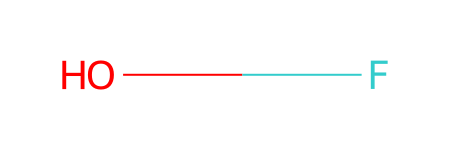

In [56]:
random_mol, random_formula = df[['mol','formula']].sample(n=1).iloc[0]
smiles = Chem.MolToSmiles(random_mol.GetMol())
print(random_formula)
print(smiles)
Chem.MolFromSmiles(smiles)

In [61]:
error_count = 0
success_count = 0

for index, row in df.iterrows():
    try:
        mol = row['mol']
        smiles = Chem.MolToSmiles(mol)
        new_mol = Chem.MolFromSmiles(smiles)
        if new_mol is not None:
            num_components = len(Chem.GetMolFrags(new_mol))
            if num_components == 1:
                success_count += 1
            else:
                error_count += 1
        else:
            error_count += 1
    except Exception as e:
        error_count += 1

print("Percentage of Valid Molecules", success_count / (error_count + success_count) * 100)

Percentage of Valid Molecules 100.0
